In this notebook, we test the linear interpolation scheme using velocity and see if it leads to less number of messages to be transmit.

In [12]:
import numpy as np 
import pickle 
from matplotlib import pyplot as plt

with open('../trajectories.pyo', 'rb') as f:
    trajectories = pickle.load(f)

t_vec = np.array(trajectories['t_vec'])
y_vec = np.array(trajectories['y_vec'])
x_vec = trajectories['x_vec']

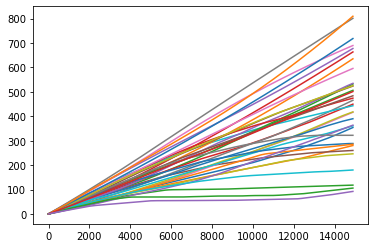

In [13]:
for i in range(35):
    plt.plot(t_vec, y_vec[i,:], label='y')

Let's use linear extrapolation over the residual trajectory for prediction on the client side 

In [14]:
def test(traj_id):
    client_y = np.zeros((t_vec.shape[0],))
    ego_y = y_vec[traj_id,:]
    client_v = np.zeros_like(client_y)
    y_last = ego_y[0]
    i_last = 0
    v_last = ego_y[1] - ego_y[0]
    rebroadcasts = 0
    for i in range(t_vec.shape[0]):
        # Make a prediction on the ego side 
        y_hat = y_last + v_last * (i - i_last)
        if np.abs(y_hat - ego_y[i])>3:
            # Trigger rebroadcast 
            rebroadcasts += 1
            client_y[i] = ego_y[i]
            v_last = ego_y[i] - ego_y[i-1]
            i_last = i
            y_last = ego_y[i]
            client_v[i] = v_last
        else:
            client_y[i] = y_hat
            client_v[i] = v_last

    return rebroadcasts, client_y, client_v

In [15]:
rebroadcast_log = np.zeros((y_vec.shape[0],))
for i in range(y_vec.shape[0]):
    rebroadcasts, client_y, client_v = test(i)
    rebroadcast_log[i] = rebroadcasts

(array([ 1.,  0.,  1.,  0.,  5.,  0., 12.,  0., 39.,  0., 48.,  0., 41.,
         0., 34.,  0., 14.,  0.,  3.,  2.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <BarContainer object of 20 artists>)

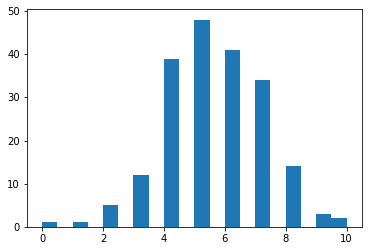

In [16]:
plt.hist(rebroadcast_log, bins=20)

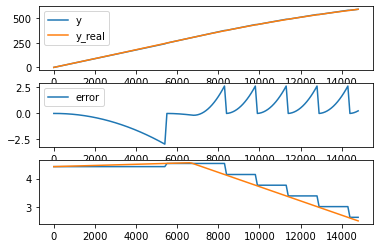

In [18]:
ego_y = y_vec[-1,:]
ego_yv = np.diff(ego_y)
plt.subplot(3,1,1)
plt.plot(t_vec[:-1], client_y[:-1], label='y')
plt.plot(t_vec[:-1], ego_y[:-1], label='y_real')
plt.legend()
plt.subplot(3,1,2)
plt.plot(t_vec[:-1], client_y[:-1] - ego_y[:-1], label='error')
plt.legend()
plt.subplot(3,1,3)
plt.plot(t_vec[:-1], client_v[:-1], label='v')
plt.plot(t_vec[:-1], ego_yv, label='v_real')

In [17]:
print('Mean: ', np.mean(rebroadcast_log))
print('Std: ', np.std(rebroadcast_log))

Mean:  5.43
Std:  1.6386274744431695
